In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy

In [2]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation','relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']

In [3]:
def process_adult(df):
    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace(' ?',np.nan)
    df['workclass'] = df['workclass'].replace(' ?',np.nan)
    df['occupation'] = df['occupation'].replace(' ?',np.nan)
    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1}).astype(int)
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['workclass'] = df['workclass'].map({' Never-worked': 0, ' Without-pay': 1, ' State-gov': 2, ' Local-gov': 3, ' Federal-gov': 4, ' Self-emp-inc': 5, ' Self-emp-not-inc': 6, ' Private': 7}).astype(int)
    df['education'] = df['education'].map({' Preschool': 0, ' 1st-4th': 1, ' 5th-6th': 2, ' 7th-8th': 3, ' 9th': 4, ' 10th': 5, ' 11th': 6, ' 12th': 7, ' HS-grad':8, ' Some-college': 9, ' Bachelors': 10, ' Prof-school': 11, ' Assoc-acdm': 12, ' Assoc-voc': 13, ' Masters': 14, ' Doctorate': 15}).astype(int)
    df['marital'] = df['marital'].map({' Married-civ-spouse': 2, ' Divorced': 1, ' Never-married': 0, ' Separated': 1, ' Widowed': 1, ' Married-spouse-absent': 2, ' Married-AF-spouse': 2}).astype(int)
    df['relationship'] = df['relationship'].map({' Wife': 1 , ' Own-child': 0 , ' Husband': 1, ' Not-in-family': 0, ' Other-relative': 0, ' Unmarried': 0}).astype(int)
    df['race'] = df['race'].map({' White': 1, ' Asian-Pac-Islander': 0, ' Amer-Indian-Eskimo': 0, ' Other': 0, ' Black': 0}).astype(int)
    df['gender'] = df['gender'].map({' Male': 1, ' Female': 0}).astype(int)
    # process hours
    df.loc[(df['hours'] <= 40), 'hours'] = 0
    df.loc[(df['hours'] > 40), 'hours'] = 1
    df = df.drop(columns=['fnlwgt', 'education.num', 'occupation', 'country', 'capgain', 'caploss'])
    df = df.reset_index(drop=True)
    return df


In [4]:
df_train = pd.read_csv('adult.data', names = cols, sep=",")


In [5]:
df_train.size

488415

In [6]:
df_test = pd.read_csv('adult.test', names = cols, sep = ",")

In [7]:
df_train.head()

,age,workclass,fnlwgt,education,education.num,marital,occupation,relationship,race,gender,capgain,caploss,hours,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
df_train = process_adult(df_train)

In [9]:
df_train.head()

,age,workclass,education,marital,relationship,race,gender,hours,income
0,0,2,10,0,0,1,1,0,0
1,1,6,10,2,1,1,1,0,0
2,0,7,8,1,0,1,1,0,0
3,1,7,6,2,1,0,1,0,0
4,0,7,10,2,1,0,0,0,0


In [10]:
unique_income_values = df_test['income'].unique()

print(unique_income_values)

[nan ' <=50K.' ' >50K.']


In [11]:
df_test.head()

,age,workclass,fnlwgt,education,education.num,marital,occupation,relationship,race,gender,capgain,caploss,hours,country,income
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [12]:
def process_adult_test(df):
    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace(' ?',np.nan)
    df['workclass'] = df['workclass'].replace(' ?',np.nan)
    df['occupation'] = df['occupation'].replace(' ?',np.nan)
    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['age'] = df['age'].astype(int)
    df['income'] = df['income'].map({' <=50K.': 0, ' >50K.': 1}).astype(int)
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['workclass'] = df['workclass'].map({' Never-worked': 0, ' Without-pay': 1, ' State-gov': 2, ' Local-gov': 3, ' Federal-gov': 4, ' Self-emp-inc': 5, ' Self-emp-not-inc': 6, ' Private': 7}).astype(int)
    df['education'] = df['education'].map({' Preschool': 0, ' 1st-4th': 1, ' 5th-6th': 2, ' 7th-8th': 3, ' 9th': 4, ' 10th': 5, ' 11th': 6, ' 12th': 7, ' HS-grad':8, ' Some-college': 9, ' Bachelors': 10, ' Prof-school': 11, ' Assoc-acdm': 12, ' Assoc-voc': 13, ' Masters': 14, ' Doctorate': 15}).astype(int)
    df['marital'] = df['marital'].map({' Married-civ-spouse': 2, ' Divorced': 1, ' Never-married': 0, ' Separated': 1, ' Widowed': 1, ' Married-spouse-absent': 2, ' Married-AF-spouse': 2}).astype(int)
    df['relationship'] = df['relationship'].map({' Wife': 1 , ' Own-child': 0 , ' Husband': 1, ' Not-in-family': 0, ' Other-relative': 0, ' Unmarried': 0}).astype(int)
    df['race'] = df['race'].map({' White': 1, ' Asian-Pac-Islander': 0, ' Amer-Indian-Eskimo': 0, ' Other': 0, ' Black': 0}).astype(int)
    df['gender'] = df['gender'].map({' Male': 1, ' Female': 0}).astype(int)
    # process hours
    df.loc[(df['hours'] <= 40), 'hours'] = 0
    df.loc[(df['hours'] > 40), 'hours'] = 1
    df = df.drop(columns=['fnlwgt', 'education.num', 'occupation', 'country', 'capgain', 'caploss'])
    df = df.reset_index(drop=True)
    return df


In [13]:
df_test = process_adult_test(df_test)

In [14]:
df_test.head()

,age,workclass,education,marital,relationship,race,gender,hours,income
0,0,7,6,0,0,0,1,0.0,0
1,0,7,8,2,1,1,1,1.0,0
2,0,3,12,2,1,1,1,0.0,1
3,0,7,9,2,1,0,1,0.0,1
4,0,7,5,0,0,1,1,0.0,0


In [15]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
X_train = df_train.drop(columns='income')
y_train = df_train['income']

X_test = df_test.drop(columns='income')
y_test = df_test['income']

In [16]:
filtered_df = df_train

In [17]:
df_train.head()

,age,workclass,education,marital,relationship,race,gender,hours,income
0,0,2,10,0,0,1,1,0,0
1,1,6,10,2,1,1,1,0,0
2,0,7,8,1,0,1,1,0,0
3,1,7,6,2,1,0,1,0,0
4,0,7,10,2,1,0,0,0,0


In [18]:
df_train.size

271458

In [19]:
X_train.size

241296

In [20]:
X_test.head()

,age,workclass,education,marital,relationship,race,gender,hours
0,0,7,6,0,0,0,1,0.0
1,0,7,8,2,1,1,1,1.0
2,0,3,12,2,1,1,1,0.0
3,0,7,9,2,1,0,1,0.0
4,0,7,5,0,0,1,1,0.0


In [21]:
y_test.head()

0    0
1    0
2    1
3    1
4    0
Name: income, dtype: int32

In [22]:
X_train.head()

,age,workclass,education,marital,relationship,race,gender,hours
0,0,2,10,0,0,1,1,0
1,1,6,10,2,1,1,1,0
2,0,7,8,1,0,1,1,0
3,1,7,6,2,1,0,1,0
4,0,7,10,2,1,0,0,0


In [23]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int32

In [24]:
clf_name = 'LogisticRegression'

In [25]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)
    x_train_scalar_temp = sc.fit_transform(x_train_temp)
    # y_train_scalar_temp = sc.fit_transform(y_train_temp)
    clf = eval(clf_name)(input_size=x_train_temp.shape[-1])
    clf.fit(x_train_scalar_temp, y_train_temp)

    y_pred_proba_temp = clf.predict_proba(x_test_scalar_temp)

    privileged_gp_indices = x_test_temp[x_test_temp['gender'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['gender'] == 0].index  # male: 1, female: 0

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    return  protected_positive_pred - privileged_positive_pred

In [26]:
dp_ori = demographic_parity(X_train, y_train, X_test)
print(dp_ori)

-0.18778662219152922


In [27]:
x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)
sc = StandardScaler()
print(len(x_train_a))
print(len(X_test))

30162
15060


In [28]:
x_train_ca = x_train_a
y_train_ca = y_train_a

In [29]:
# COVERAGE BASED ACQUISITION
#for threshold = 500, 1 MUP = XXXXX001, 286dp TBA
#for threshold = 1000, 1 MUP = XXXXX0X1, 259dp TBA
#for threshold = 2000, 1 MUP = XXXXXX01, 340dp TBA
#for threshold = 8000, 1 MUP = ['XXXXXX11', 'XXXXXX01'], 463dp, 6340 TBA
#for threshold = 10000, 1 MUP = XXXXXXX1, 803dp TBA
#for threshold = 20000, 1 MUP = XXXXXXX1, 10803dp TBA

def coverage_acqui(data_acqui_count, filtered_df, x_train_ca, y_train_ca):
    
       filtered_df_x = filtered_df[['age', 'workclass', 'education', 'marital','relationship', 'race', 'gender','hours']]
       
       filtered_df_y = filtered_df[['income']]
       filtered_df_y = sc.fit_transform(filtered_df_y)

       filtered_df_sc = sc.fit_transform(filtered_df_x)

       for i in range(data_acqui_count):
              index = i%len(filtered_df_x)
              x_train_ca = np.append(x_train_ca, [filtered_df_sc[index]], axis=0)
              y_train_ca = np.append(y_train_ca, [filtered_df_y[index]])

       dp_ca = demographic_parity(x_train_ca, y_train_ca, X_test)
       print(len(x_train_ca))
       print(dp_ca)
       return x_train_ca, y_train_ca

In [72]:
# COVERAGE BASED ACQUISITION for one threshold - for comp plot

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

x_train_ca = x_train_a
y_train_ca = y_train_a

print(len(x_train_ca))
filtered_df_h1 = filtered_df[(filtered_df['hours'] == 1)]
dp = {}
counts_to_check = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 15800]
current_count = 0
    
filtered_df_x = filtered_df[['age', 'workclass', 'education', 'marital','relationship', 'race', 'gender','hours']]

filtered_df_y = filtered_df[['income']]
filtered_df_y = sc.fit_transform(filtered_df_y)

filtered_df_sc = sc.fit_transform(filtered_df_x)

for count in counts_to_check:
    target_count = counts_to_check[counts_to_check.index(count) + 1] - count if count != counts_to_check[-1] else counts_to_check[-1]
    while target_count > 0:
        index = current_count % len(filtered_df_x)
        x_train_ca = np.append(x_train_ca, [filtered_df_sc[index]], axis=0)
        y_train_ca = np.append(y_train_ca, [filtered_df_y[index]])
        current_count += 1
        target_count -= 1
        if current_count in counts_to_check:
            print(len(x_train_ca))
            dp[current_count] = demographic_parity(x_train_ca, y_train_ca, X_test)
            print(f"Demographic Parity for first {current_count} data points: {dp}")
        if current_count == max(counts_to_check):
            print(current_count)
            break

print(dp)
              

30162
31162
Demographic Parity for first 1000 data points: {1000: -0.20906213439982055}
32162
Demographic Parity for first 2000 data points: {1000: -0.20906213439982055, 2000: -0.22770320610205952}
33162
Demographic Parity for first 3000 data points: {1000: -0.20906213439982055, 2000: -0.22770320610205952, 3000: -0.2459595518135851}
34162
Demographic Parity for first 4000 data points: {1000: -0.20906213439982055, 2000: -0.22770320610205952, 3000: -0.2459595518135851, 4000: -0.2624663020038739}
35162
Demographic Parity for first 5000 data points: {1000: -0.20906213439982055, 2000: -0.22770320610205952, 3000: -0.2459595518135851, 4000: -0.2624663020038739, 5000: -0.27468861938139044}
36162
Demographic Parity for first 6000 data points: {1000: -0.20906213439982055, 2000: -0.22770320610205952, 3000: -0.2459595518135851, 4000: -0.2624663020038739, 5000: -0.27468861938139044, 6000: -0.2847996730854739}
37162
Demographic Parity for first 7000 data points: {1000: -0.20906213439982055, 2000: -0

In [30]:
#for threshold = 500, 1 MUP = XXXXX001, 286dp TBA
# filtered_df_r0_go_h1 = filtered_df[(filtered_df['race'] == 0) & (filtered_df['gender'] == 0 ) & (filtered_df['hours'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(286, filtered_df_r0_go_h1, x_train_ca, y_train_ca)

#for threshold = 1000, 1 MUP = XXXXX0X1, 259dp TBA
# filtered_df_r0_h1 = filtered_df[(filtered_df['race'] == 0) & (filtered_df['hours'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(259, filtered_df_r0_h1, x_train_ca, y_train_ca)

#for threshold = 2000, 1 MUP = XXXXXX01, 340dp TBA
# filtered_df_g0_h1 = filtered_df[(filtered_df['gender'] == 0 ) & (filtered_df['hours'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(340, filtered_df_g0_h1, x_train_ca, y_train_ca)

#for threshold = 8000, 1 MUP = ['XXXXXX11', 'XXXXXX01'], 463dp, 6340 TBA
# filtered_df_g1_h1 = filtered_df[(filtered_df['gender'] == 1 ) & (filtered_df['hours'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(463, filtered_df_g1_h1, x_train_ca, y_train_ca)

# filtered_df_g0_h1 = filtered_df[(filtered_df['gender'] == 0 ) & (filtered_df['hours'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(6340, filtered_df_g0_h1, x_train_ca, y_train_ca)

#for threshold = 10000, 1 MUP = XXXXXXX1, 803dp TBA
# filtered_df_h1 = filtered_df[(filtered_df['hours'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(803, filtered_df_h1, x_train_ca, y_train_ca)

#for threshold = 20000, 1 MUP = XXXXXXX1, 10803dp TBA
filtered_df_h1 = filtered_df[(filtered_df['hours'] == 1)]
x_train_ca, y_train_ca = coverage_acqui(10803, filtered_df_h1, x_train_ca, y_train_ca)

dp_ca = demographic_parity(x_train_ca, y_train_ca, X_test)
print(dp_ca)

40965
-0.31755794671332693
-0.31755794671332693


In [31]:
#RANDOM DATA ACQUISITION
import random
#for threshold = 500, 1 MUP = XXXXX001, 286dp TBA
#for threshold = 1000, 1 MUP = XXXXX0X1, 259dp TBA
#for threshold = 2000, 1 MUP = XXXXXX01, 340dp TBA
#for threshold = 8000, 1 MUP = ['XXXXXX11', 'XXXXXX01'], 463dp, 6340 TBA
#for threshold = 10000, 1 MUP = XXXXXXX1, 803dp TBA
#for threshold = 20000, 1 MUP = XXXXXXX1, 10803dp TBA

X_train_scaler = sc.fit_transform(X_train)

counts_to_check =  [286,259, 340, 6803, 803, 10803]
# count_to_check = 41 
# count_to_check = 189 
# count_to_check = 22 
# count_to_check = 10 
# count_to_check = 1605 

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

# for i in range(count_to_check):
#     index =  random.randint(0, len(X_train_scaler) -1)
#     x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
#     y_train_a = np.append(y_train_a, [y_train[index]])

# dp_rand = demographic_parity(x_train_a, y_train_a, X_test)
# print(f"Demographic Parity for {count_to_check} random data points: {dp_rand}")
# print(len(x_train_a))




for count in counts_to_check:
    target_count = counts_to_check[counts_to_check.index(count) + 1] - count if count != counts_to_check[-1] else counts_to_check[-1]
    while target_count > 0:
        index = random.randint(0, len(X_train_scaler) -1)
        x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
        y_train_a = np.append(y_train_a, [y_train[index]])
        current_count += 1
        target_count -= 1
        if current_count in counts_to_check:
            print(len(x_train_a))
            dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
            print(f"Demographic Parity for first {current_count} data points: {dp}")
        if current_count == max(counts_to_check):
            print(current_count)
            break

print(dp)

30421
Demographic Parity for first 259 data points: {259: -0.18584968147153988}
30448
Demographic Parity for first 286 data points: {259: -0.18584968147153988, 286: -0.18585858723031287}
30502
Demographic Parity for first 340 data points: {259: -0.18584968147153988, 286: -0.18585858723031287, 340: -0.18563108454540733}
30965
Demographic Parity for first 803 data points: {259: -0.18584968147153988, 286: -0.18585858723031287, 340: -0.18563108454540733, 803: -0.18269789891315935}
36965
Demographic Parity for first 6803 data points: {259: -0.18584968147153988, 286: -0.18585858723031287, 340: -0.18563108454540733, 803: -0.18269789891315935, 6803: -0.17257946805562932}
40965
Demographic Parity for first 10803 data points: {259: -0.18584968147153988, 286: -0.18585858723031287, 340: -0.18563108454540733, 803: -0.18269789891315935, 6803: -0.17257946805562932, 10803: -0.1722147121780615}
10803
{259: -0.18584968147153988, 286: -0.18585858723031287, 340: -0.18563108454540733, 803: -0.1826978989131

In [74]:
#RANDOM DATA ACQUISITION for one threshold
import random


X_train_scaler = sc.fit_transform(X_train)

counts_to_check =  [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 15800]
# count_to_check = 41 
# count_to_check = 189 
# count_to_check = 22 
# count_to_check = 10 
# count_to_check = 1605 

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}


for count in counts_to_check:
    target_count = counts_to_check[counts_to_check.index(count) + 1] - count if count != counts_to_check[-1] else counts_to_check[-1]
    while target_count > 0:
        index = random.randint(0, len(X_train_scaler) -1)
        x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
        y_train_a = np.append(y_train_a, [y_train[index]])
        current_count += 1
        target_count -= 1
        if current_count in counts_to_check:
            print(len(x_train_a))
            dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
            print(f"Demographic Parity for first {current_count} data points: {dp}")
        if current_count == max(counts_to_check):
            print(current_count)
            break

print(dp)

31162
Demographic Parity for first 1000 data points: {1000: -0.18146309901439028}
32162
Demographic Parity for first 2000 data points: {1000: -0.18146309901439028, 2000: -0.17921454375953488}
33162
Demographic Parity for first 3000 data points: {1000: -0.18146309901439028, 2000: -0.17921454375953488, 3000: -0.17700961785227923}
34162
Demographic Parity for first 4000 data points: {1000: -0.18146309901439028, 2000: -0.17921454375953488, 3000: -0.17700961785227923, 4000: -0.17527634842454684}
35162
Demographic Parity for first 5000 data points: {1000: -0.18146309901439028, 2000: -0.17921454375953488, 3000: -0.17700961785227923, 4000: -0.17527634842454684, 5000: -0.17515241372844978}
36162
Demographic Parity for first 6000 data points: {1000: -0.18146309901439028, 2000: -0.17921454375953488, 3000: -0.17700961785227923, 4000: -0.17527634842454684, 5000: -0.17515241372844978, 6000: -0.1738824176367792}
37162
Demographic Parity for first 7000 data points: {1000: -0.18146309901439028, 2000: -

In [32]:
x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)
sc = StandardScaler()
x_train_a = sc.fit_transform(x_train_a)
X_train_copy = np.copy(X_train)
X_train_scaler = sc.fit_transform(X_train_copy)

result_plot = []
result = {}

for i in range(len(X_train)):
    x_train_new = np.append(x_train_a, [X_train_scaler[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, X_test)
    result[i] = res
    result_plot.append(res)

# Sort the dictionary based on the values (res)
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

In [33]:
len(X_train_scaler)

30162

In [34]:
sorted_result = dict(sorted(result.items(), key=lambda item: item[1]))

In [35]:
counts_to_check = [0, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 10000 data points: {0: -0.18778662219152922, 10000: -0.008790160450611262}
Demographic Parity for first 11000 data points: {0: -0.18778662219152922, 10000: -0.008790160450611262, 11000: -0.014049770924815408}
Demographic Parity for first 12000 data points: {0: -0.18778662219152922, 10000: -0.008790160450611262, 11000: -0.014049770924815408, 12000: -0.018643832519049774}
Demographic Parity for first 13000 data points: {0: -0.18778662219152922, 10000: -0.008790160450611262, 11000: -0.014049770924815408, 12000: -0.018643832519049774, 13000: -0.022544679241428778}
Demographic Parity for first 14000 data points: {0: -0.18778662219152922, 10000: -0.008790160450611262, 11000: -0.014049770924815408, 12000: -0.018643832519049774, 13000: -0.022544679241428778, 14000: -0.02527825597151928}
Demographic Parity for first 15000 data points: {0: -0.18778662219152922, 10000: -0.008790160450611262, 11000: -0.014049770924815408, 12000: -0.018643832519049774, 13000: -0.0225446

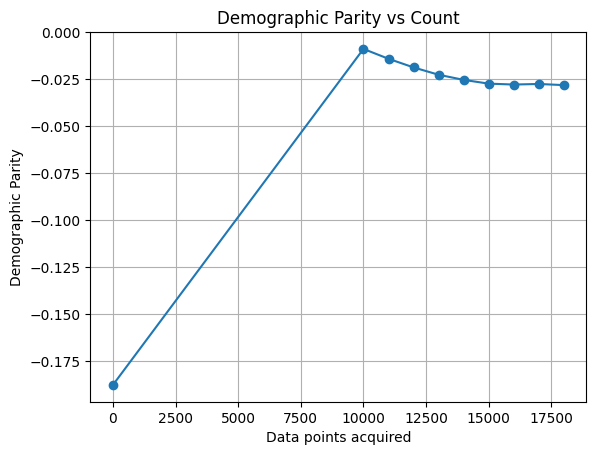

In [36]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [37]:
counts_to_check = [7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

# dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 7000 data points: {7000: 0.0020875045470328812}
Demographic Parity for first 7500 data points: {7000: 0.0020875045470328812, 7500: 0.0016946533480826642}
Demographic Parity for first 8000 data points: {7000: 0.0020875045470328812, 7500: 0.0016946533480826642, 8000: 0.0005224693275656112}
Demographic Parity for first 8500 data points: {7000: 0.0020875045470328812, 7500: 0.0016946533480826642, 8000: 0.0005224693275656112, 8500: -0.001770411891643453}
Demographic Parity for first 9000 data points: {7000: 0.0020875045470328812, 7500: 0.0016946533480826642, 8000: 0.0005224693275656112, 8500: -0.001770411891643453, 9000: -0.004592083472304498}
Demographic Parity for first 9500 data points: {7000: 0.0020875045470328812, 7500: 0.0016946533480826642, 8000: 0.0005224693275656112, 8500: -0.001770411891643453, 9000: -0.004592083472304498, 9500: -0.00671311293979221}
Demographic Parity for first 10000 data points: {7000: 0.0020875045470328812, 7500: 0.001694653348082664

In [38]:
X_train.size


241296

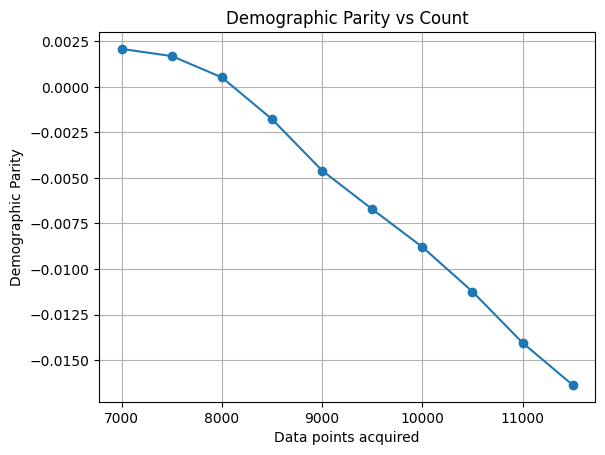

In [39]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [40]:
#8100 datapoints can be acquired to decrease the demographic parity

In [41]:
clf = eval('LogisticRegression')(input_size=X_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_test_scaler = sc.fit_transform(X_test)

In [43]:
del_F_del_theta = del_spd_del_theta_ad(clf, X_test, x_test_scaler, y_test)

In [44]:
hessian_all_points = get_hessian_all_points(clf, X_train_scaler, y_train, loss_func)

  0%|          | 0/30162 [00:00<?, ?it/s]

100%|██████████| 30162/30162 [01:59<00:00, 252.56it/s]


In [45]:
del_L_del_theta = get_del_L_del_theta(clf, X_train_scaler, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(30162, 9)


In [46]:
X_train_scaler.size

241296

In [47]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 

In [48]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta)) 

In [49]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
inf = inf / 30162
print(inf.shape)

(30162,)


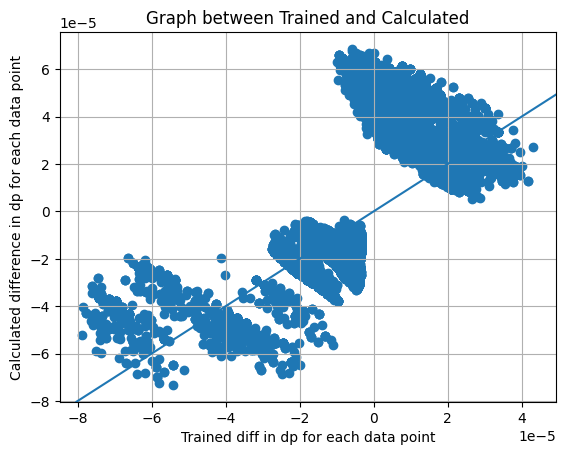

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df = pd.DataFrame({'Trained': result_plot, 'Calculated': inf})
ax.scatter(df['Trained'], df['Calculated'], marker='o')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained diff in dp for each data point')
plt.ylabel('Calculated difference in dp for each data point')
plt.grid(True)

ax.axline((0, 0), slope=1)
plt.show()


In [51]:
inf_list = {index: value for index, value in enumerate(inf)}

In [52]:
# INFLUENCE BASED SORTED DP FOR EACH DATA POINT
sorted_result_inf = {k: v for k, v in sorted(inf_list.items(), key=lambda item: item[1])}

In [53]:
counts_to_check = [0, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp_inf = {}

dp_inf[0] = dp_ori

for index, res in sorted_result_inf.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp_inf[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp_inf}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 10000 data points: {0: -0.18778662219152922, 10000: -0.03159159129298539}
Demographic Parity for first 11000 data points: {0: -0.18778662219152922, 10000: -0.03159159129298539, 11000: -0.031861147706493786}
Demographic Parity for first 12000 data points: {0: -0.18778662219152922, 10000: -0.03159159129298539, 11000: -0.031861147706493786, 12000: -0.03133367882404814}
Demographic Parity for first 13000 data points: {0: -0.18778662219152922, 10000: -0.03159159129298539, 11000: -0.031861147706493786, 12000: -0.03133367882404814, 13000: -0.030500726195052397}
Demographic Parity for first 14000 data points: {0: -0.18778662219152922, 10000: -0.03159159129298539, 11000: -0.031861147706493786, 12000: -0.03133367882404814, 13000: -0.030500726195052397, 14000: -0.02993540683616161}
Demographic Parity for first 15000 data points: {0: -0.18778662219152922, 10000: -0.03159159129298539, 11000: -0.031861147706493786, 12000: -0.03133367882404814, 13000: -0.03050072619505239

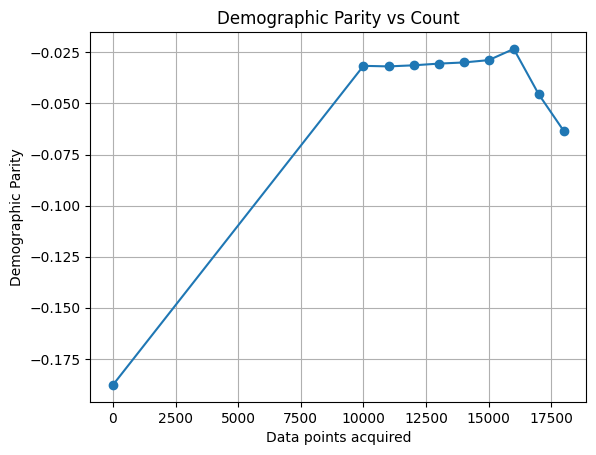

In [54]:
import matplotlib.pyplot as plt

counts = list(dp_inf.keys())
dp_inf_values = list(dp_inf.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_inf_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [55]:
counts_to_check = [15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800, 15900, 16000, 16100, 16200, 16300, 16400, 16500]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp_inf = {}

# dp_inf[0] = -0.07884407

for index, res in sorted_result_inf.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp_inf[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp_inf}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 15000 data points: {15000: -0.028795331868317148}
Demographic Parity for first 15100 data points: {15000: -0.028795331868317148, 15100: -0.02861942398215231}
Demographic Parity for first 15200 data points: {15000: -0.028795331868317148, 15100: -0.02861942398215231, 15200: -0.02752832162434185}
Demographic Parity for first 15300 data points: {15000: -0.028795331868317148, 15100: -0.02861942398215231, 15200: -0.02752832162434185, 15300: -0.026325115663703408}
Demographic Parity for first 15400 data points: {15000: -0.028795331868317148, 15100: -0.02861942398215231, 15200: -0.02752832162434185, 15300: -0.026325115663703408, 15400: -0.025633199400342505}
Demographic Parity for first 15500 data points: {15000: -0.028795331868317148, 15100: -0.02861942398215231, 15200: -0.02752832162434185, 15300: -0.026325115663703408, 15400: -0.025633199400342505, 15500: -0.024246240419561027}
Demographic Parity for first 15600 data points: {15000: -0.028795331868317148, 15100:

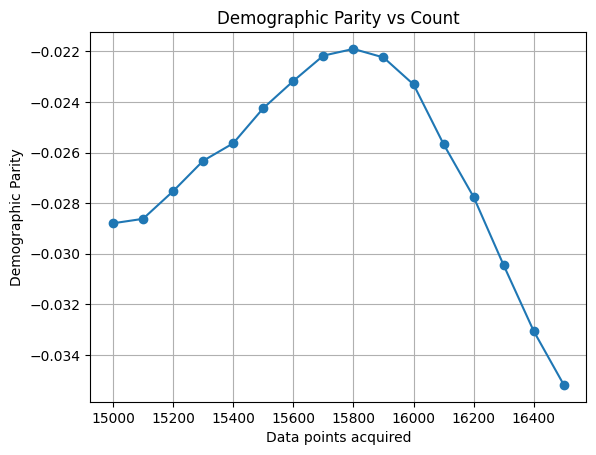

In [56]:
import matplotlib.pyplot as plt

counts = list(dp_inf.keys())
dp_inf_values = list(dp_inf.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_inf_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [57]:
#15800 data points

In [61]:
counts_to_check = [286,259, 340, 6803, 803, 12000, 10803]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp_inf = {}

# dp_inf[0] = -0.07884407

for index, res in sorted_result_inf.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp_inf[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp_inf}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 259 data points: {259: -0.14291108530757}
Demographic Parity for first 286 data points: {259: -0.14291108530757, 286: -0.13936611594867382}
Demographic Parity for first 340 data points: {259: -0.14291108530757, 286: -0.13936611594867382, 340: -0.13282154763977133}
Demographic Parity for first 803 data points: {259: -0.14291108530757, 286: -0.13936611594867382, 340: -0.13282154763977133, 803: -0.09113492628344083}
Demographic Parity for first 6803 data points: {259: -0.14291108530757, 286: -0.13936611594867382, 340: -0.13282154763977133, 803: -0.09113492628344083, 6803: -0.03094145339905291}
Demographic Parity for first 10803 data points: {259: -0.14291108530757, 286: -0.13936611594867382, 340: -0.13282154763977133, 803: -0.09113492628344083, 6803: -0.03094145339905291, 10803: -0.03151421317782649}
Demographic Parity for first 12000 data points: {259: -0.14291108530757, 286: -0.13936611594867382, 340: -0.13282154763977133, 803: -0.09113492628344083, 6803: -0

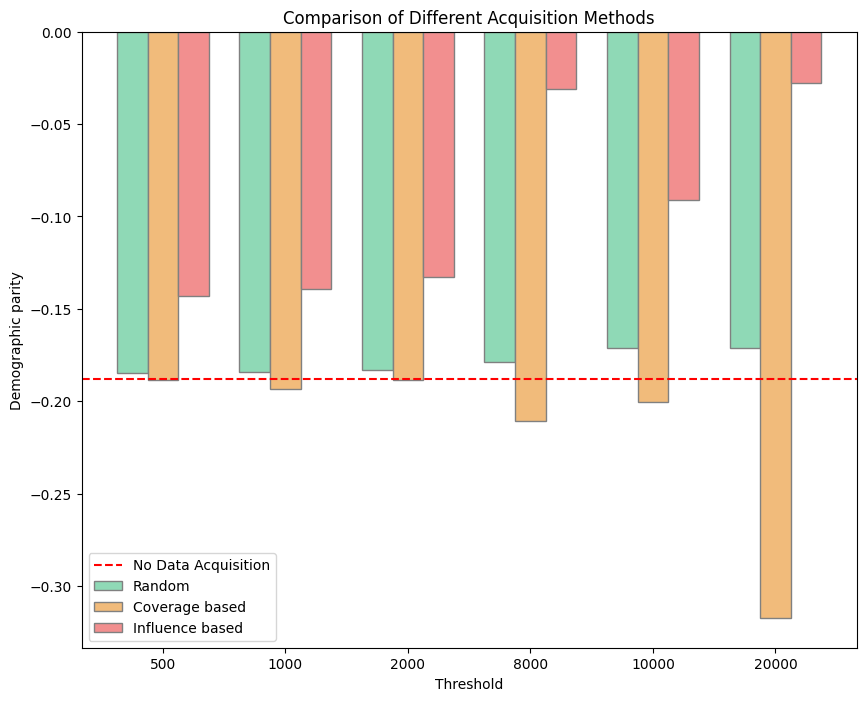

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Data for each acquisition method
random_data = [[500, -0.18469], [1000, -0.18423], [2000, -0.18304], [8000, -0.17890], [10000, -0.171305], [20000, -0.17135]] 
coverage_based_data = [[500, -0.18836], [1000, -0.19358], [2000, -0.18844], [8000, -0.210603], [10000, -0.20062], [20000, -0.31755]]
influence_based_data = [[500, -0.142911], [1000, -0.1393661], [2000, -0.132821], [8000, -0.03094], [10000, -0.09113], [20000, -0.027941]]

# Extracting x and y values for each method
threshold_random, dp_random = zip(*random_data)
threshold_coverage, dp_coverage = zip(*coverage_based_data)
threshold_influence, dp_influence = zip(*influence_based_data)

# Set width of bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(threshold_random))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


# Plotting the bars
plt.figure(figsize=(10, 8))  # Adjust figure size
plt.bar(r1, dp_random, color='#8fd9b6', width=bar_width, edgecolor='grey', label='Random')
plt.bar(r2, dp_coverage, color='#f1bb7b', width=bar_width, edgecolor='grey', label='Coverage based')
plt.bar(r3, dp_influence, color='#f28f8f', width=bar_width, edgecolor='grey', label='Influence based')

plt.axhline(y=-0.18778, color='red', linestyle='--', label='No Data Acquisition')

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Demographic parity')
plt.title('Comparison of Different Acquisition Methods')
plt.xticks([r + bar_width for r in range(len(threshold_random))], threshold_random)
plt.legend(loc='lower left')  # Adjust legend position

# Show plot
plt.show()


In [ ]:
counts_to_check = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 15800]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp_inf = {}

dp_inf[0] = dp_ori

for index, res in sorted_result_inf.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train_scaler[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp_inf[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp_inf}")
    
    if current_count == max(counts_to_check):
        break

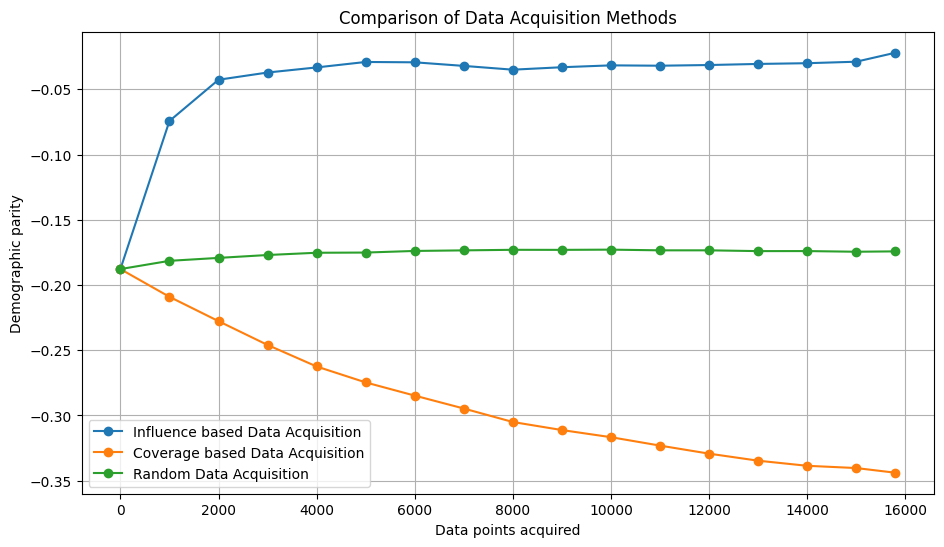

In [76]:
# Data for Influence based Data Acquisition calculating influence 
counts1 = list(dp_inf.keys())
# counts_modified1 = [count / 8 for count in counts1]
dp_values1 = list(dp_inf.values())


# Data for Coverage based Data Acquisition
counts2 = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 15800]
dp_values2 = [-0.18778, -0.209062, -0.227703, -0.245959, -0.262466, -0.27468, -0.28479, -0.294687, -0.30503, -0.31120, -0.316670, -0.32312, -0.32929, -0.334692, -0.3386, -0.340336, -0.34392]


# Data for Random Data Acquisition
counts3 = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 15800]
dp_values3 = [-0.18778, -0.18146, -0.17921, -0.1770, -0.17527, -0.17512, -0.17388, -0.17344, -0.17301, -0.17305, -0.17288, -0.17341, -0.17341, -0.174009, -0.17398, -0.17449, -0.17421]

plt.figure(figsize=(11, 6)) 

# Plotting the dp values against the counts
plt.plot(counts1, dp_values1, marker='o', label='Influence based Data Acquisition')
plt.plot(counts2, dp_values2, marker='o', label='Coverage based Data Acquisition')
plt.plot(counts3, dp_values3, marker='o', label='Random Data Acquisition')

plt.title('Comparison of Data Acquisition Methods')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic parity')
plt.grid(True)
plt.legend()  # Show legend with labels
plt.show()